# Network Gaussian example N=10

## Setup and packages

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

graphics_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/ND examples/Network Gaussian 10"

In [2]:
N = 10
Rho = np.zeros((N,N))

Rho[0,1] = 0.7

Rho[4,5] = 0.5

Rho[1,6] = 0.3
Rho[5,6] = 0.3

Rho[5,7] = 0.7

Rho[3,8] = 0.3
Rho[7,8] = 0.3

Rho[6,9] = 0.4
Rho[8,9] = 0.2

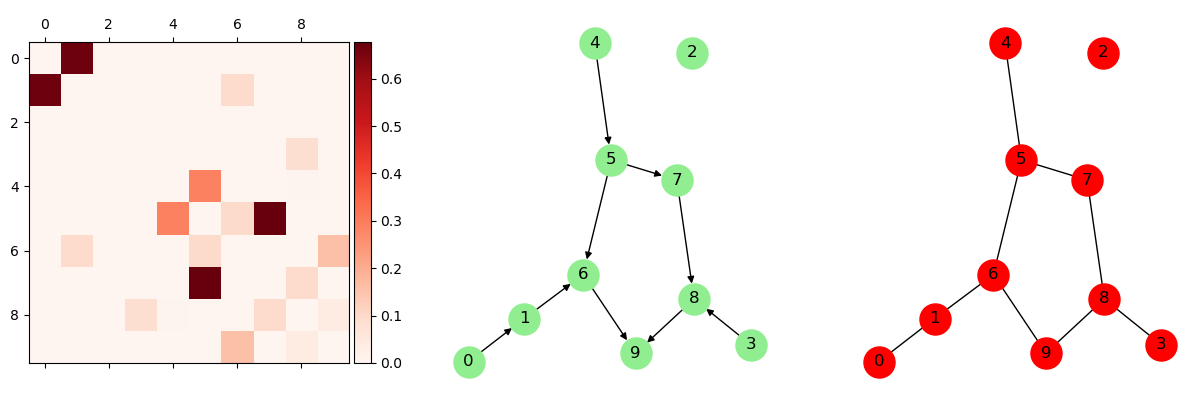

In [3]:
alpha = 1.07
ConvolvedInformation = Rho + Rho.T
ConvolvedInformation = -1/2*np.log(1-ConvolvedInformation**2)
ConvolvedInformation = ConvolvedInformation @ np.linalg.pinv(alpha * np.identity(N) - ConvolvedInformation)

DeconvoledInformation = ND(ConvolvedInformation,alpha = 1)


fig, ax = plt.subplots(1,3,figsize=(15,5))


r = ax.flat[0].matshow(DeconvoledInformation, cmap = "Reds", vmin = 0)
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);


# Directed graph from initial correlation structure (non-symmetric)
am = Rho.copy()
am[am > 0] = 1
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am, create_using = nx.DiGraph)

nx.draw(gr, pos=graphviz_layout(gr), node_size = 500, with_labels= True, ax = ax.flat[1], node_color='lightgreen')


am = DeconvoledInformation.copy()
t = 0.01
am[am > t] = 1
am[am < t] = 0
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am)

nx.draw(gr, pos=graphviz_layout(gr), node_size = 500, with_labels= True, ax = ax.flat[2], node_color='red')

Text(0.5, 1.0, 'Convolved information using $ \\rho $')

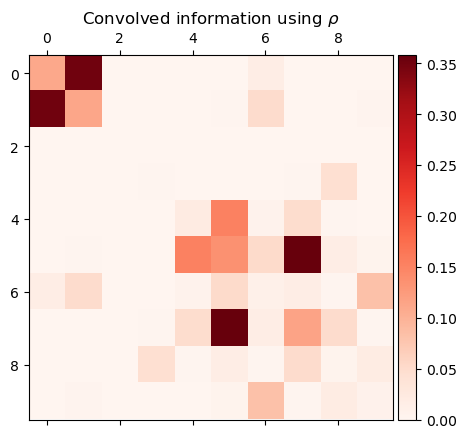

In [4]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

r = ax.matshow(ConvolvedInformation, cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.set_title("Convolved information using " + r"$ \rho $")

## Data sampling

In [5]:
A = np.zeros((N,N))

for i in range(N):
    sum_ = (Rho[:,i]**2).sum()
    A[i,:] = (Rho[:,i][:,None] * A).sum(axis=0)
    A[i,i] = np.sqrt(1- sum_)

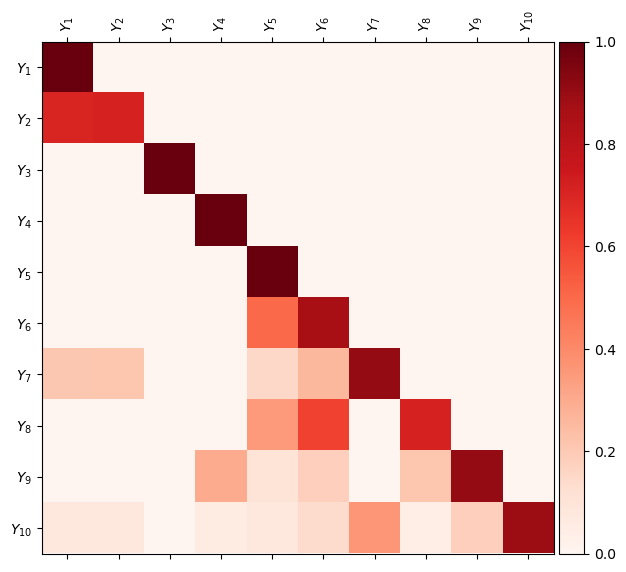

In [6]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
r = ax.matshow(A, cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(r, cax=cax)

ax.set_xticks([x for x in range(N)], GenLabels("Y", N), rotation='vertical');
ax.set_yticks([x for x in range(N)], GenLabels("Y", N));

In [7]:
n_sample = 10_000
mean = np.zeros(N)

Z = np.random.default_rng().multivariate_normal(mean = mean, cov = np.identity(N), size = n_sample).T
Y = (A @ Z)

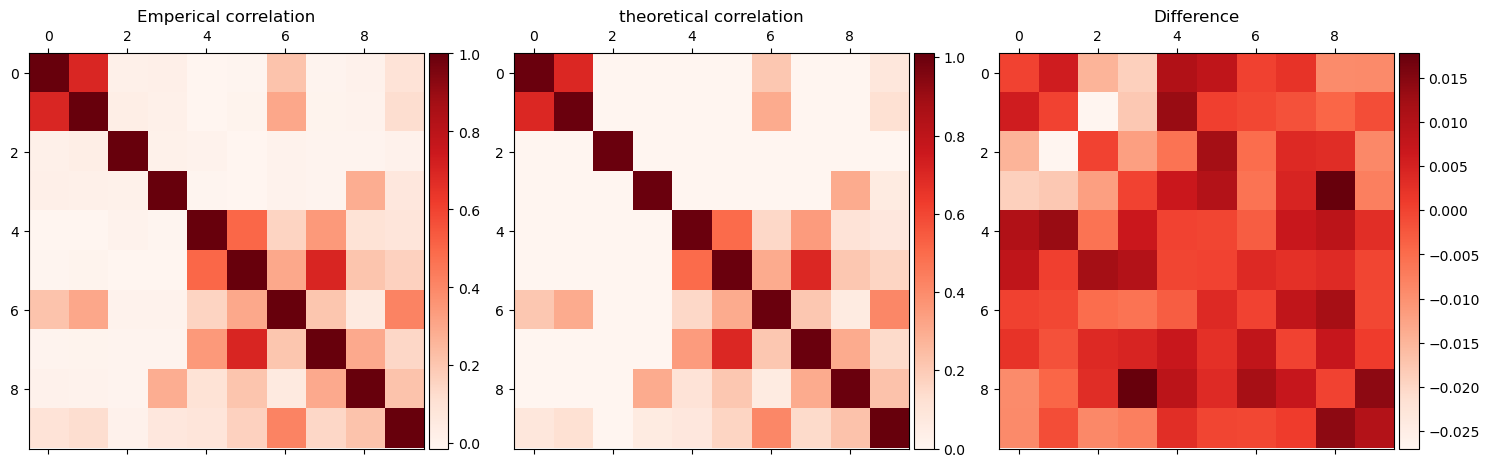

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,7))

r = ax.flat[0].matshow(np.corrcoef(Y), cmap = "Reds")
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[0].set_title("Emperical correlation")


r = ax.flat[1].matshow(A @ A.T, cmap = "Reds")
divider = make_axes_locatable(ax.flat[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[1].set_title("theoretical correlation")



r = ax.flat[2].matshow(A @ A.T - np.corrcoef(Y), cmap = "Reds")
divider = make_axes_locatable(ax.flat[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[2].set_title("Difference")

fig.tight_layout()

C:\Users\jonas\AppData\Local\Temp\ipykernel_17720\1604308173.py:1: RuntimeWarning: divide by zero encountered in log
  MI_from_A = np.nan_to_num(-1/2 * np.log( 1 - (A @ A.T)**2))
C:\Users\jonas\AppData\Local\Temp\ipykernel_17720\1604308173.py:1: RuntimeWarning: invalid value encountered in log
  MI_from_A = np.nan_to_num(-1/2 * np.log( 1 - (A @ A.T)**2))


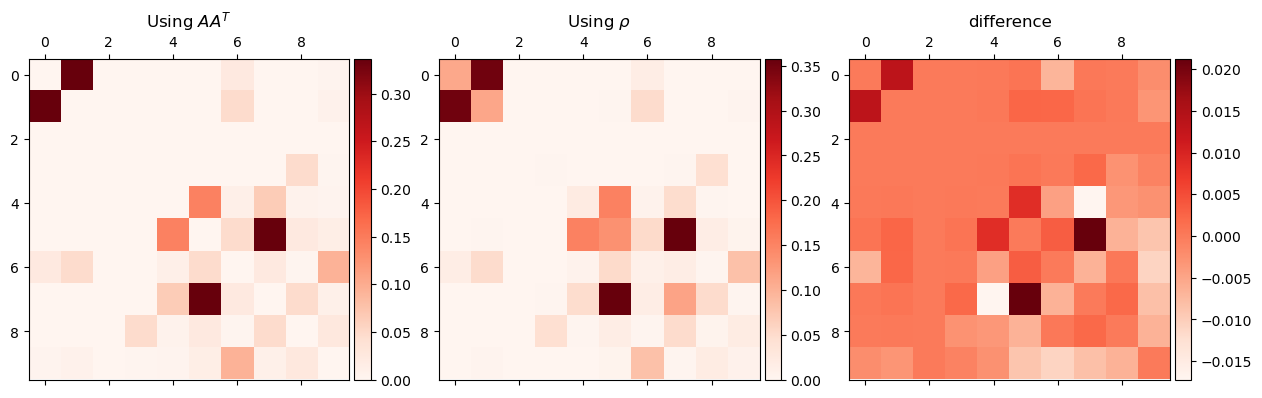

In [10]:
MI_from_A = np.nan_to_num(-1/2 * np.log( 1 - (A @ A.T)**2))
np.fill_diagonal(MI_from_A,0)


l1 = np.triu(MI_from_A).max()
l2 = np.triu(ConvolvedInformation).max()


fig, ax = plt.subplots(1,3,figsize=(15,5))
r = ax.flat[0].matshow(MI_from_A, cmap = "Reds")
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[0].set_title("Using " + r"$A A^T$")


r = ax.flat[1].matshow(ConvolvedInformation, cmap = "Reds")
divider = make_axes_locatable(ax.flat[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[1].set_title("Using " + r"$\rho$");


temp = ConvolvedInformation - MI_from_A
np.fill_diagonal(temp, 0)
r = ax.flat[2].matshow(temp, cmap = "Reds")
divider = make_axes_locatable(ax.flat[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
ax.flat[2].set_title("difference");

## $G_{obs}$

In [11]:
# Prepare Kernels, transformed data to uniform (from kernel), Scott's optimal bandwiths
kernels_Y = [gaussian_kde(Y[i,:]) for i in tqdm(range(N))]

U = np.vstack( [np.array([kernels_Y[i].integrate_box_1d(-np.inf, x_i) for x_i in Y[i,:]]) for i in tqdm(range(N)) ])
kernels_U = [gaussian_kde(U[i,:]) for i in tqdm(range(N))]

h = np.array([(kernels_Y[i].covariance**0.5)[0,0] for i in tqdm(range(N))])

100%|██████████| 10/10 [00:00<?, ?it/s]


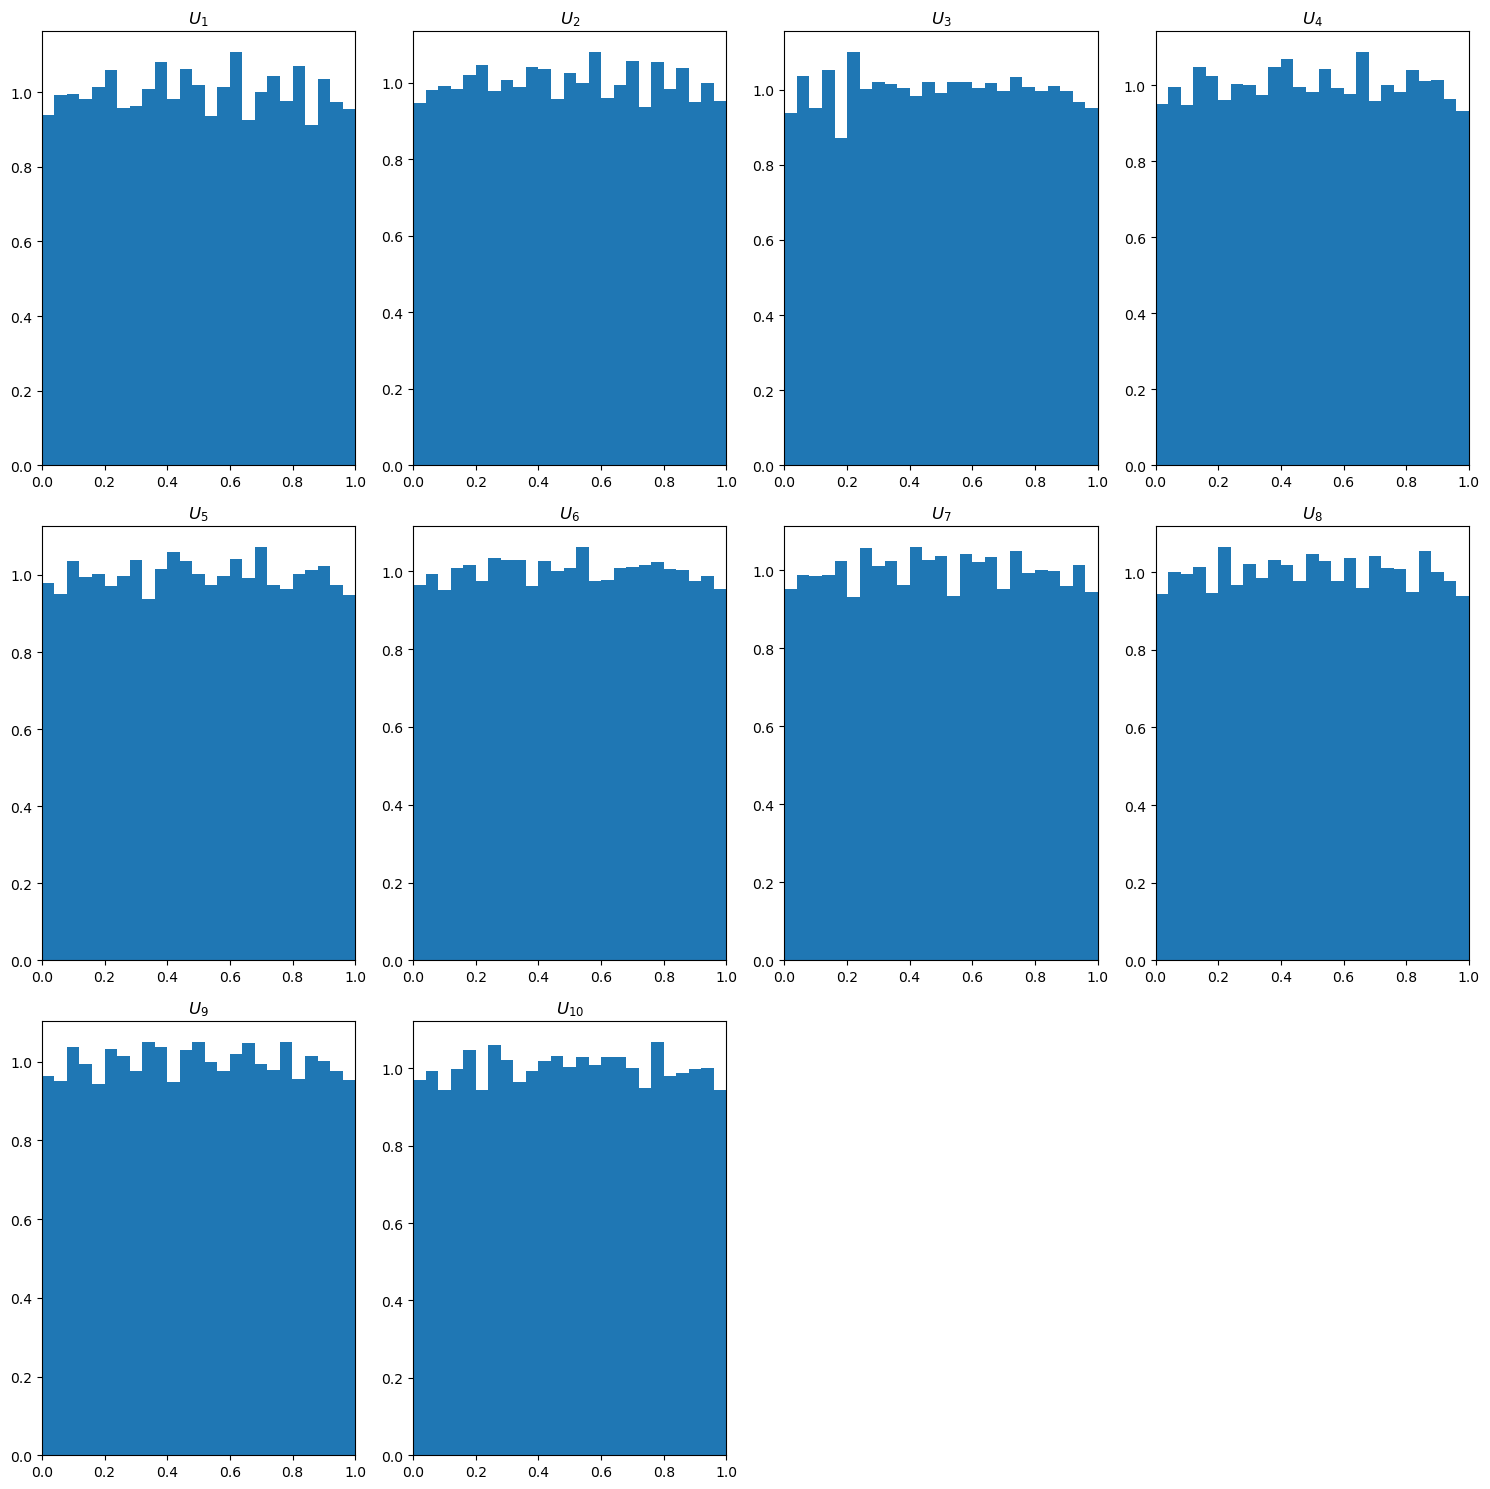

In [137]:
n_cols = int(np.ceil(np.sqrt(N)))
n_rows = int(np.ceil(N / n_cols))
fig, ax = plt.subplots(n_rows,n_cols, figsize=(15,15))

for i in range(N):
    ax.flat[i].hist(U[i,:], density=True, bins = 25)
    ax.flat[i].set_title("$U_{" +f"{i+1}" + "}$")
    ax.flat[i].set_xlim([0,1])

for i in range(N,n_rows*n_cols):
    ax.flat[i].axis("off")

fig.tight_layout()

In [42]:
try:
    with open('Example Network Gaussian 10 GObs.pkl', 'rb') as f:
        G_obs = pickle.load(f)
except:
    G_obs = np.zeros((N,N))
    count = 0
    for i in range(N-1):
        u_i = U[i,:]
        for j in range(i+1, N):
            print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")

            u_j = U[j,:]

            kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))

            d_vol = kernel_ij.integrate_box(
                    low_bounds = [0,0],
                    high_bounds = [1,1]
                )
            
            # Simple normalization of KDE such that integrates to 1 (no jackknifing)
            G_obs[i,j] = G_obs[j,i] = \
                dblquad(
                    lambda x,y : 
                        kernel_ij.pdf(np.vstack([x,y])) * \
                        kernel_ij.logpdf(np.vstack([x,y])),
                    0,1,
                    0,1
                )[0] / d_vol - np.log(d_vol)

            count += 1
            print(f"{ count } / { (N*(N-1)/2) :3.0f}    [{100*count/ (N*(N-1)/2) :7.2f}%]    ({i}, {j})\033[K", end ="\r")
        
    with open('Example Network Gaussian 10 GObs.pkl', 'wb') as f:
        pickle.dump(G_obs, f)

In [12]:
i,j = 0,1
u_i, u_j = U[i,:], U[j,:]
kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))
n_mesh = 100
Y1v, Y2v = np.meshgrid(
    np.linspace(0,1,n_mesh), 
    np.linspace(0,1,n_mesh))

Zv = np.reshape(kernel_ij.evaluate(np.vstack([Y1v.ravel(), Y2v.ravel()])), (n_mesh,n_mesh))

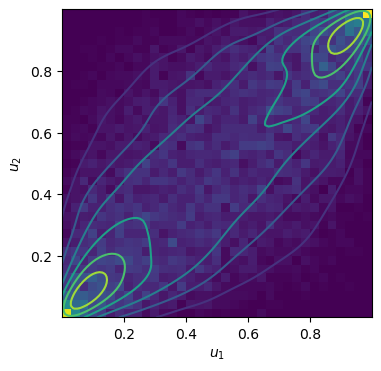

In [356]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.contour(Y1v, Y2v, Zv );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i, u_j, density=True, bins = (35,35));

In [149]:
kernel_ij.logpdf(np.array([[0.5,0.5]]))

array([0.39674103])

In [156]:
kernel_ij.covariance

array([[0.00381499, 0.00260824],
       [0.00260824, 0.00381567]])

In [158]:
kernel_ij.cho_cov @ kernel_ij.cho_cov.T

array([[0.00381499, 0.00260824],
       [0.00260824, 0.00381567]])

In [12]:
u_i.min()

8.519519387231943e-05

In [13]:
(res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()

C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2978230862.py:1: RuntimeWarning: divide by zero encountered in log
  (res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()
C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2978230862.py:1: RuntimeWarning: invalid value encountered in multiply
  (res[1][1:] - res[1][:-1]).min()**2 * np.nan_to_num(res[0] * np.log(res[0])).sum()


0.38774103798615334

In [14]:
r = range(20,100)
E = np.zeros(r.__len__())
for idx, n_bins in enumerate(r):


    res = np.histogram2d(u_i, u_j, density=True, bins = (n_bins,n_bins))

    # plt.matshow(res[0])

    # plt.matshow(np.imag(np.fft.fft2(res[0])))


    fft_res = np.fft.fft2(res[0])
    rows, cols = fft_res.shape
    crow, ccol = rows // 2, cols // 2

    fft_percent_radius = 0.7
    fft_radius = int(min(crow, ccol) * (1-fft_percent_radius) )

    fft_shift_res = np.fft.fftshift(fft_res)
    fft_shift_res[crow - fft_radius:crow + fft_radius, ccol - fft_radius:ccol + fft_radius] = 0

    fft_shift_res_inv = np.fft.ifftshift(fft_shift_res)
    mod_fft = np.fft.ifft2(fft_shift_res_inv)



    # imag_fft = np.imag(fft_res)
    # real_fft = np.real(fft_res)
    # q = np.quantile(np.abs(imag_fft).ravel(), 0.6)
    # # q = 2
    # real_fft[np.abs(imag_fft) > q] = 0
    # # imag_fft[np.abs(imag_fft) > q] = 0


    # mod_fft = real_fft + imag_fft

    # ifft_res = np.fft.ifft2(mod_fft)

    # plt.matshow(np.real(ifft_res))
    # plt.matshow(np.imag(ifft_res))



    E[idx] = np.abs(np.abs(mod_fft) - res[0]).mean()

    # plt.matshow(np.abs(mod_fft))

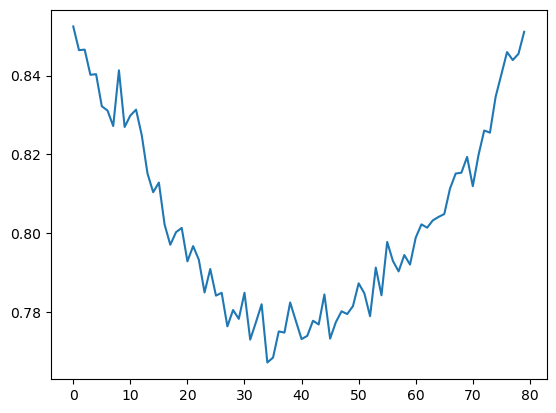

In [15]:
plt.plot(E)

C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2104005326.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(xx,np.nan_to_num(np.log(xx)*xx))
C:\Users\jonas\AppData\Local\Temp\ipykernel_20076\2104005326.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.plot(xx,np.nan_to_num(np.log(xx)*xx))


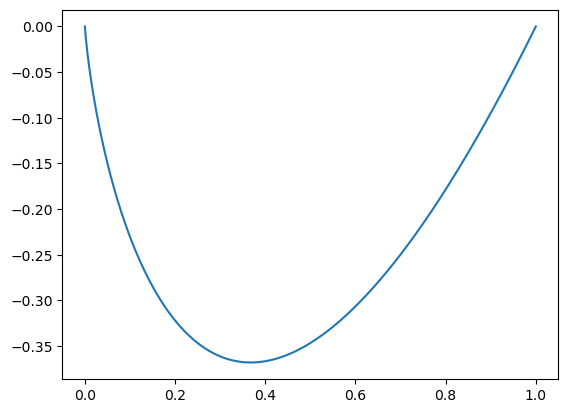

In [16]:
xx = np.linspace(0,1,1000)
plt.plot(xx,np.nan_to_num(np.log(xx)*xx))

In [17]:
np.quantile(np.abs(np.imag(np.fft.fft2(res[0]))).ravel(), 0.95)

141.64894996960203

In [34]:
n_mesh = 100
uu1, uu2 = np.meshgrid(
    np.linspace(1/(2*n_mesh),1 - 1/(2*n_mesh),n_mesh),
    np.linspace(1/(2*n_mesh),1 - 1/(2*n_mesh),n_mesh)
)

In [35]:

pdfij = kernel_ij.evaluate(np.vstack([uu1.ravel(), uu2.ravel()]))
pdfij_log = kernel_ij.logpdf(np.vstack([uu1.ravel(), uu2.ravel()]))

In [36]:
vol = 1/n_mesh**2 * pdfij.sum()
MI = 1/n_mesh**2 * (pdfij * pdfij_log).sum() / vol - np.log(vol)

MI

# 100: 0.27505222880680286
# 200: 0.27509714064787716

0.27505222880680286

In [37]:
G_obs[i,j]

0.2725824834476379

In [21]:
G_obs_theoretical[i,j]

0.32652431826055756

In [85]:
res[1]

array([1.23038018e-04, 5.00036519e-01, 9.99950000e-01])

In [94]:
np.where( (u_i < 0.5) & (u_i > 0) & (u_j < 0.5) & (u_j > 0) )[0].__len__()

3724

In [96]:
np.where( (u_i > 0.5) & (u_i < 1) & (u_j > 0.5) & (u_j < 1) )[0].__len__()

3726

In [97]:
np.where( (u_i > 0.5) & (u_i < 1) & (u_j < 0.5) & (u_j > 0) )[0].__len__()

1268

In [14]:
log = np.where( (u_i < 0.5) & (u_i > 0) & (u_j < 0.5) & (u_j > 0) )[0]

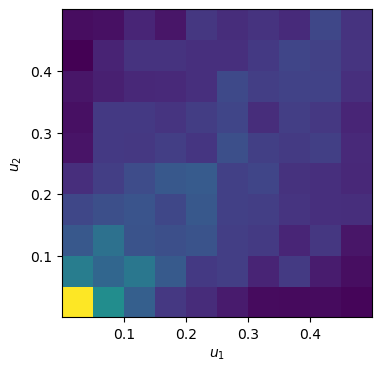

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i[log], u_j[log], density=True, bins = (10,10));

C:\Users\jonas\AppData\Local\Temp\ipykernel_17720\384188164.py:7: RuntimeWarning: divide by zero encountered in log
  (res[0] * np.nan_to_num(np.log(res[0]))).mean()


4.6187550287979775

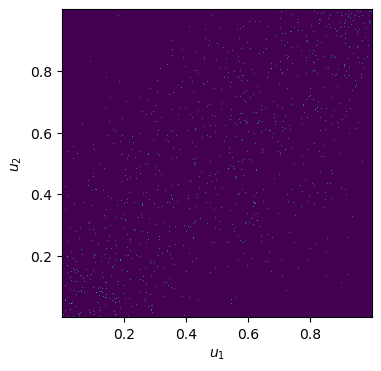

In [80]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i, u_j, density=True, bins = (1000,1000));

(res[0] * np.nan_to_num(np.log(res[0]))).mean()

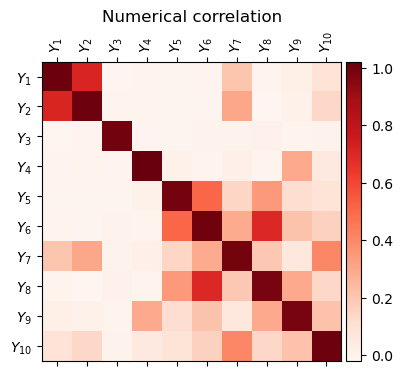

In [8]:
num_corr = np.cov(Y)

fig, ax = plt.subplots(1,1,figsize=(4,4))
r = ax.matshow(num_corr, cmap = "Reds")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax);
fig.tight_layout()
ax.set_title("Numerical correlation")
VariableMatrixSetLabels(ax, N, "Y")

plt.savefig(graphics_path + "/Numerical Correlation", bbox_inches='tight')
plt.savefig(graphics_path + "/Numerical Correlation.pdf", bbox_inches='tight')

In [18]:

temp = -1/2*np.log(1-(A @ A.T)**2)
np.fill_diagonal(temp,0)
temp

C:\Users\jonas\AppData\Local\Temp\ipykernel_13168\829781099.py:1: RuntimeWarning: divide by zero encountered in log
  temp = -1/2*np.log(1-(A @ A.T)**2)
C:\Users\jonas\AppData\Local\Temp\ipykernel_13168\829781099.py:1: RuntimeWarning: invalid value encountered in log
  temp = -1/2*np.log(1-(A @ A.T)**2)


array([[ 0.        ,  0.33667228, -0.        , -0.        , -0.        ,
        -0.        ,  0.02255099, -0.        , -0.        ,  0.00354051],
       [ 0.33667228,  0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.04715534, -0.        , -0.        ,  0.00725234],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.04715534,  0.00180325],
       [-0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.14384104,  0.01137849,  0.06533916,  0.00554311,  0.00329131],
       [-0.        , -0.        , -0.        , -0.        ,  0.14384104,
         0.        ,  0.04715534,  0.33667228,  0.02255099,  0.01329726],
       [ 0.02255099,  0.04715534, -0.        , -0.        ,  0.01137849,
         0.04715534,  0.        ,  0.02255099

In [19]:
G_obs_theoretical

array([[-0.00000000e+00,  3.49227902e-01,  2.35780836e-04,
         8.08626254e-05,  1.00263434e-04,  4.06166095e-05,
         2.17906358e-02,  3.39331264e-05,  1.35006347e-04,
         3.95300511e-03],
       [ 3.49227902e-01, -0.00000000e+00,  8.08609297e-05,
         2.81737957e-05,  1.09484404e-04,  1.07568798e-04,
         4.74752571e-02,  2.34183056e-04,  1.53646541e-05,
         9.04648115e-03],
       [ 2.35780836e-04,  8.08609297e-05, -0.00000000e+00,
         8.35269331e-05,  1.05665729e-04,  3.04245393e-06,
         1.21606063e-05,  2.28237435e-06,  2.50324131e-05,
         2.09641592e-06],
       [ 8.08626254e-05,  2.81737957e-05,  8.35269331e-05,
        -0.00000000e+00,  1.22492079e-05,  2.02910517e-05,
         3.79384939e-05,  2.38011144e-05,  4.50357336e-02,
         1.28863547e-03],
       [ 1.00263434e-04,  1.09484404e-04,  1.05665729e-04,
         1.22492079e-05, -0.00000000e+00,  1.48539448e-01,
         1.02400114e-02,  6.50164684e-02,  6.81462290e-03,
         3.

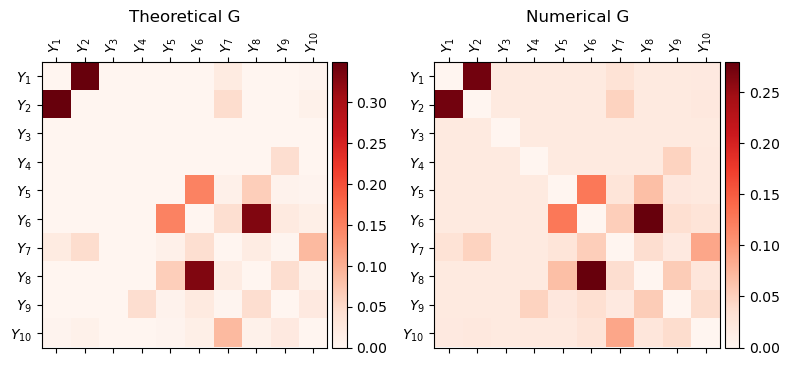

In [44]:
temp = num_corr.copy()
np.fill_diagonal(temp,0)
G_obs_theoretical = -1/2*np.log(1-temp**2)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# Theoretical G
r = ax.flat[0].matshow(G_obs_theoretical, cmap = "Reds")
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax)
VariableMatrixSetLabels(ax.flat[0], N, "Y")
ax.flat[0].set_title("Theoretical G")

# Numerically optained G
r = ax.flat[1].matshow(G_obs, cmap = "Reds")
divider = make_axes_locatable(ax.flat[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(r, cax=cax)
VariableMatrixSetLabels(ax.flat[1], N, "Y")
ax.flat[1].set_title("Numerical G")
fig.tight_layout()

# plt.savefig(graphics_path + "/GObs theoretical and numerical comparisson", bbox_inches='tight')
# plt.savefig(graphics_path + "/GObs theoretical and numerical comparisson.pdf", bbox_inches='tight')

In [109]:
def PlotInformationMatrix(G,ax = None, vmin = 0, title = None):
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (4,4))
    N = G.shape[0]
    r = ax.matshow(G, cmap = "Reds", vmin = vmin)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(r, cax=cax)
    VariableMatrixSetLabels(ax, N, "Y")
    if title:
        ax.set_title(title)

## $G_{dir}$

In [110]:
G_obs_theoretical = A @ A.T
np.fill_diagonal(G_obs_theoretical, 0)
G_obs_theoretical = -0.5 * np.log( 1 - (G_obs_theoretical)**2 )

In [111]:
np.linalg.eig(G_obs_theoretical)

EigResult(eigenvalues=array([ 0.40842273,  0.34379044, -0.33752765, -0.34816828,  0.08423188,
        0.04409733, -0.10099135, -0.03720366, -0.05665144, -0.        ]), eigenvectors=array([[-7.86477717e-02, -6.90167434e-01, -7.01133242e-01,
         5.50934015e-02,  1.21072676e-01, -4.11499794e-02,
         7.50938783e-02,  1.79508683e-02,  2.33901142e-02,
         0.00000000e+00],
       [-8.41707853e-02, -6.95275791e-01,  7.06188965e-01,
        -6.05932558e-02,  7.89026540e-02, -2.36168078e-02,
         1.54604238e-02,  6.96182269e-03,  7.84744503e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.43425093e-02,  1.82157819e-03,  6.52183863e-04,
         6.41150815e-03, -1.38011565e-01, -6.92435831e-01,
         1.10361901e-01, -5.60852968e-01, -4.17730857e-01,
         0.00000000e+00],
       

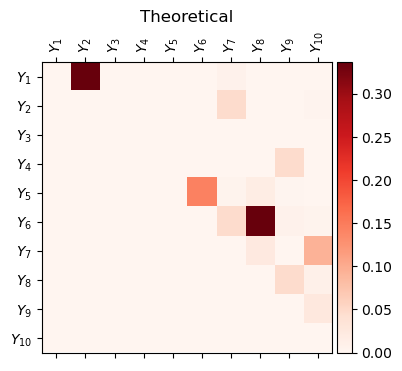

In [112]:
PlotInformationMatrix(np.triu(G_obs_theoretical) @ np.linalg.pinv( np.eye(10) + np.triu(G_obs_theoretical)), title="Theoretical")

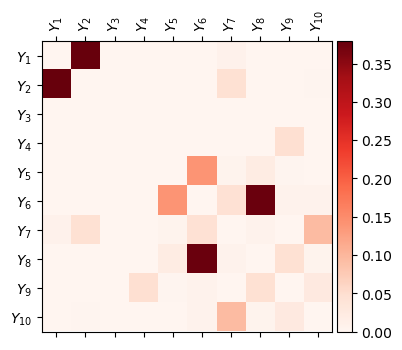

In [113]:
# plt.matshow(G_obs_theoretical @ np.linalg.pinv( np.eye(10) + G_obs_theoretical ) ,vmin = 0)
PlotInformationMatrix(G_obs_theoretical @ np.linalg.pinv( np.eye(10) + G_obs_theoretical ))

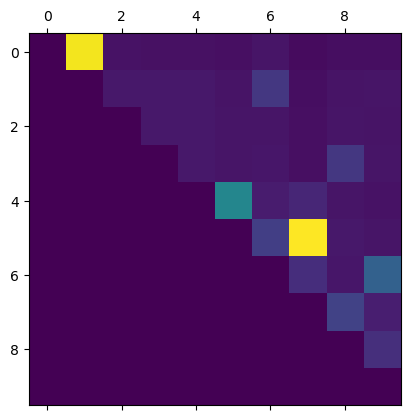

In [84]:
plt.matshow(np.triu(G_obs) @ np.linalg.pinv( np.eye(10) + np.triu(G_obs)))

In [77]:
( np.triu(G_obs_theoretical) @ np.linalg.pinv( np.eye(10) + np.triu(G_obs_theoretical)) )[6,7]

0.022550986956210085

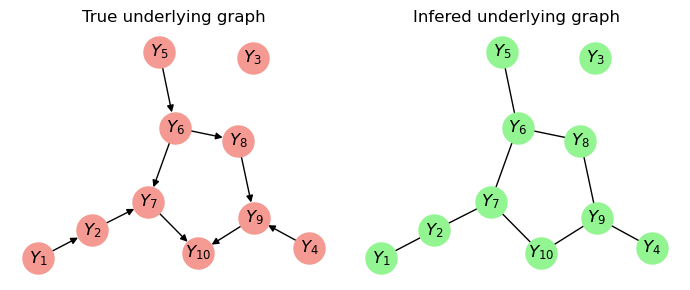

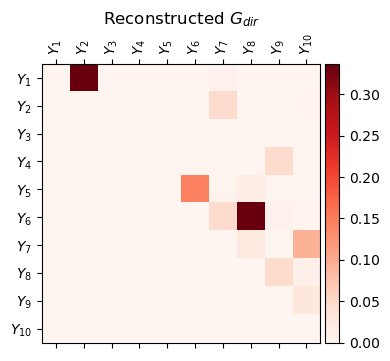

In [83]:
# G_dir = ND(G_obs, alpha=1)
# G_dir = ND(G_obs_theoretical, alpha=0.7, beta=0.999)
G_dir = np.triu(G_obs_theoretical) @ np.linalg.pinv( np.eye(10) + np.triu(G_obs_theoretical))


# Ground truth result
fig, ax = plt.subplots(1,2, figsize=(7,3))
am = Rho.copy()
am[am > 0] = 1
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am, create_using = nx.DiGraph)
pos = graphviz_layout(gr)
nx.draw(gr, pos=pos, node_size = 500, with_labels= True, ax = ax.flat[0], node_color='#F59A92', labels = { k:v for (k,v) in zip(range(N), GenLabels("Y", N))} )
ax.flat[0].set_title("True underlying graph")


am = G_dir.copy()
t = 0.025
am[am > t] = 1
am[am < t] = 0
np.fill_diagonal(am,0)
gr = nx.from_numpy_array(am)
pos = graphviz_layout(gr)
nx.draw(gr, pos = pos, node_size = 500, with_labels= True, ax = ax.flat[1], node_color='#93F592', labels = { k:v for (k,v) in zip(range(N), GenLabels("Y", N))} )
ax.flat[1].set_title("Infered underlying graph")

for a in ax.flat:
    a.patch.set_linewidth(10)
    a.patch.set_edgecolor('pink')

fig.tight_layout()

# plt.savefig(graphics_path + "/underlying graphs comparisson", bbox_inches='tight')
# plt.savefig(graphics_path + "/underlying graphs comparisson.pdf", bbox_inches='tight')



fig, ax = plt.subplots(1,1,figsize=(4,4))
r = ax.matshow(G_dir, cmap = "Reds", vmin=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title("Reconstructed " + "$G_{dir}$")
VariableMatrixSetLabels(ax, N, "Y")
plt.colorbar(r, cax=cax)
fig.tight_layout()
plt.savefig(graphics_path + "/Reconstructed GDir", bbox_inches='tight');
plt.savefig(graphics_path + "/Reconstructed GDir.pdf", bbox_inches='tight');

In [29]:
for i in range(10_000):
    scipy.integrate.quad(lambda x : np.exp(-1/2*x**2)*x**2,0,1)

In [30]:
xi = np.array([0,0.9])[None,:]
h = np.array([0.1])

a0 = ComputeA0(xi, h)
a1 = ComputeA1(xi, h)
a2 = ComputeA2(xi, h)

100%|██████████| 1/1 [00:00<00:00, 30.26it/s]


In [31]:
a0



array([[0.5       , 0.84134475]])

In [32]:
a1

array([[ 0.39894228, -0.24197072]])

In [33]:
a2

array([[0.5       , 0.59937402]])

In [34]:
U.shape

NameError: name 'U' is not defined

In [ ]:
h.shape

(10,)

In [ ]:
print("computing a0...", end="\r")
a0_all = ComputeA0(U,h)

print("computing a1...", end="\r")
a1_all = ComputeA1(U,h)

print("computing a2...", end="\r")
a2_all = ComputeA2(U,h)

100%|██████████| 10/10 [12:10<00:00, 73.06s/it]


100%|██████████| 10/10 [12:47<00:00, 76.79s/it]


In [ ]:
with open('Example Network Gaussian 10 a0_all.pkl', 'wb') as f:
    pickle.dump(a0_all, f)

with open('Example Network Gaussian 10 a1_all.pkl', 'wb') as f:
    pickle.dump(a1_all, f)

with open('Example Network Gaussian 10 a2_all.pkl', 'wb') as f:
    pickle.dump(a2_all, f)

In [14]:
try:
    with open('Example Network Gaussian 10 a0_all.pkl', 'rb') as f:
        a0_all = pickle.load(f)

    with open('Example Network Gaussian 10 a1_all.pkl', 'rb') as f:
        a1_all = pickle.load(f)

    with open('Example Network Gaussian 10 a2_all.pkl', 'rb') as f:
        a2_all = pickle.load(f)

except:
    print("øv")

In [15]:
a2_all

array([[0.96397451, 0.67344456, 0.51416892, ..., 0.92585567, 0.79936433,
        0.98044471],
       [0.7656636 , 0.96997071, 0.52721818, ..., 0.88063697, 0.84636409,
        0.91037448],
       [0.53009363, 0.97921374, 0.61958207, ..., 0.50198596, 0.51025661,
        0.50614321],
       ...,
       [0.68030687, 0.80013529, 0.58321344, ..., 0.56547124, 0.50163196,
        0.95942931],
       [0.83806492, 0.96727619, 0.50027678, ..., 0.96730328, 0.50414267,
        0.54586618],
       [0.84804415, 0.51900314, 0.75698383, ..., 0.56839747, 0.91918284,
        0.8905174 ]])

In [20]:
a0 = ComputeA0(U, h)

In [35]:
a1_all_approx = ComputeA1Approx(U, h, 3_000)

In [36]:
a2_all_approx = ComputeA2Approx(U, h, 3_000)

In [37]:
x_eval = np.linspace(0,1,1000)
a2 = a2_all_approx
a1 = a1_all_approx

In [38]:
a1.shape

(10, 10000)

In [42]:
((x_eval[None,:] - U[0,:,None])/h[0] * a1[0,:,None]).sum(axis=0).shape

(1000,)

In [44]:
res = (np.exp(((a2[0,:,None] - a1[0,:,None]* (x_eval[None,:] - U[0,:,None])/h[0] ) / (a2[0,:,None] * a0[0,:,None] - a1[0,:,None]**2) ) - 1 - 1/2 * ((x_eval[None,:] - U[0,:,None])/h[0])**2) ).sum(axis=0) / (h[0] * np.sqrt(2*np.pi))

In [45]:
res.shape

(1000,)

(0.0, 4.435076862434366)

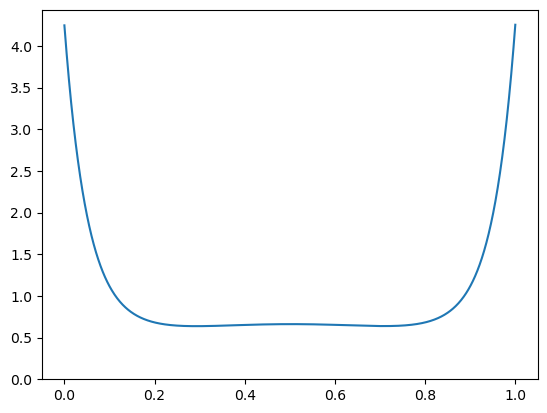

In [51]:
plt.plot(x_eval,res / res.sum()*res.shape[0])
plt.ylim(0)

In [255]:
x_eval = np.linspace(0,1,200)
y_eval = np.linspace(0,1,200)

x_eval, y_eval = np.meshgrid(x_eval, y_eval)



In [256]:
x_eval = x_eval.flatten()
y_eval = y_eval.flatten()

In [241]:
y_eval.shape

(40000,)

In [242]:
res2D = (
    np.exp(((a2[0,:,None] - a1[0,:,None]* (x_eval[None,:] - U[0,:,None])/h[0] ) / (a2[0,:,None] * a0[0,:,None] - a1[0,:,None]**2) ) - 1 - 1/2 * ((x_eval[None,:] - U[0,:,None])/h[0])**2) *
    np.exp(((a2[1,:,None] - a1[1,:,None]* (y_eval[None,:] - U[1,:,None])/h[1] ) / (a2[1,:,None] * a0[1,:,None] - a1[1,:,None]**2) ) - 1 - 1/2 * ((y_eval[None,:] - U[1,:,None])/h[1])**2) 
    ).sum(axis=0) / (h[0] * h[1] * 2*np.pi)

In [244]:
res2D = np.reshape(res2D, (200,200))
res2D = res2D / res2D.mean()

In [257]:
res2D_negative = (
    ((a2[0,:,None] - a1[0,:,None]* (x_eval[None,:] - U[0,:,None])/h[0] ) / (a2[0,:,None] * a0[0,:,None] - a1[0,:,None]**2) ) * np.exp(- 1/2 * ((x_eval[None,:] - U[0,:,None])/h[0])**2) *
    ((a2[1,:,None] - a1[1,:,None]* (y_eval[None,:] - U[1,:,None])/h[1] ) / (a2[1,:,None] * a0[1,:,None] - a1[1,:,None]**2) ) * np.exp(- 1/2 * ((y_eval[None,:] - U[1,:,None])/h[1])**2) 
    ).sum(axis=0) / (h[0] * h[1] * 2*np.pi)

res2D_negative = np.reshape(res2D_negative, (200,200))
res2D_negative = res2D_negative / res2D_negative.mean()

In [246]:
res2D_basic = (
    np.exp( - 1/2 * ((x_eval[None,:] - U[0,:,None])/h[0])**2) *
    np.exp( - 1/2 * ((y_eval[None,:] - U[1,:,None])/h[1])**2) 
    ).sum(axis=0) / (h[0] * h[1] * 2*np.pi)

res2D_basic = np.reshape(res2D_basic, (200,200))

res2D_basic = res2D_basic / res2D_basic.mean()

In [264]:
res2D_nonnegative = res2D_basic * np.exp(res2D_negative / res2D_basic - 1)
res2D_nonnegative = res2D_nonnegative / res2D_nonnegative.mean()

In [247]:
x_eval = np.linspace(0.0001,0.9999,300)
y_eval = np.linspace(0.0001,0.9999,300)

x_eval, y_eval = np.meshgrid(x_eval, y_eval)


qx = scipy.stats.norm().ppf(x_eval)
qy = scipy.stats.norm().ppf(y_eval)

rho = 0.7
res2D_theoretical = np.nan_to_num(1/np.sqrt(1 - rho**2) * np.exp( - (rho**2 * qx**2 - 2*rho*qx*qy + rho**2 * qy**2) / ( 2*(1-rho**2))))


# np.reshape(np.nan_to_num(scipy.stats.multivariate_normal(np.zeros((2)), cov = np.array([[1,rho],[rho,1]])).pdf( np.vstack((qx.flatten(), qy.flatten())).T )), (100,100))

Text(0.5, 1.0, 'Theoretical')

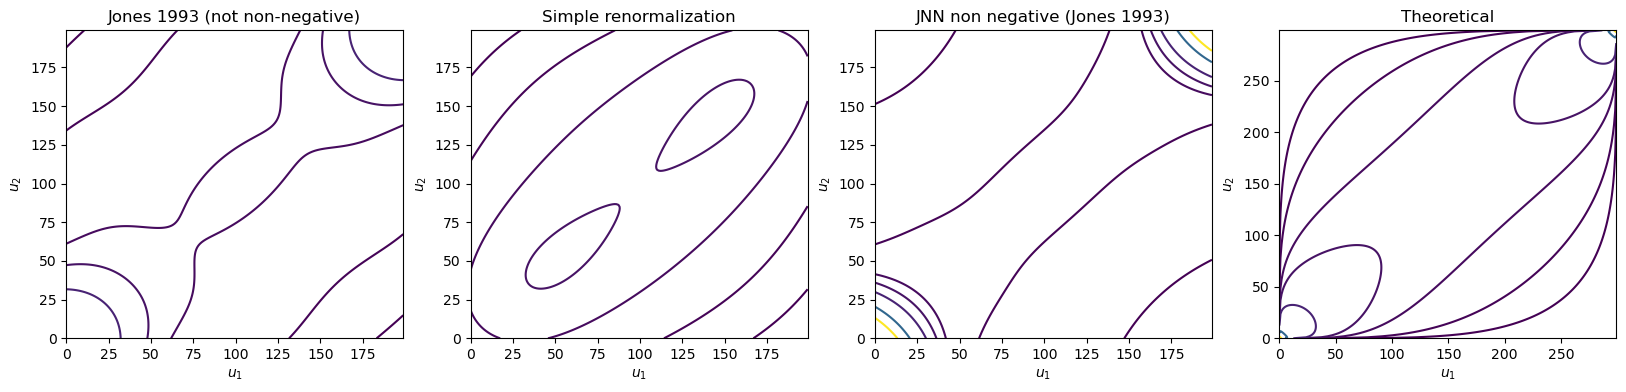

In [265]:
fig, ax = plt.subplots(1,4, figsize=(20,4))
# ax.contour(res2D , levels= np.exp(np.linspace(-10,np.log(50),100)));

alpha = 5
levels = np.linspace(0, 40**(1/alpha),20)**alpha 

levels = [0.1, 0.37, 1, 1.6, 3, 10, 30]

ax.flat[0].contour(res2D_negative , levels= levels );
ax.flat[0].set_xlabel("$u_1$")
ax.flat[0].set_ylabel("$u_2$")
ax.flat[0].set_title("Jones 1993 (not non-negative)")



ax.flat[1].contour(res2D_basic , levels= levels );
ax.flat[1].set_xlabel("$u_1$")
ax.flat[1].set_ylabel("$u_2$")
ax.flat[1].set_title("Simple renormalization")


ax.flat[2].contour(res2D_nonnegative , levels= levels );
ax.flat[2].set_xlabel("$u_1$")
ax.flat[2].set_ylabel("$u_2$")
ax.flat[2].set_title("JNN non negative (Jones 1993)")



ax.flat[3].contour(res2D_theoretical , levels= levels );
ax.flat[3].set_xlabel("$u_1$")
ax.flat[3].set_ylabel("$u_2$")
ax.flat[3].set_title("Theoretical")

In [358]:
i,j = 0,1
u_i, u_j = U[i,:], U[j,:]
kernel_ij = gaussian_kde(np.vstack([u_i,u_j]))
n_mesh = 100
Y1v, Y2v = np.meshgrid(
    np.linspace(0,1,n_mesh), 
    np.linspace(0,1,n_mesh))

Zv = np.reshape(kernel_ij.evaluate(np.vstack([Y1v.ravel(), Y2v.ravel()])), (n_mesh,n_mesh))

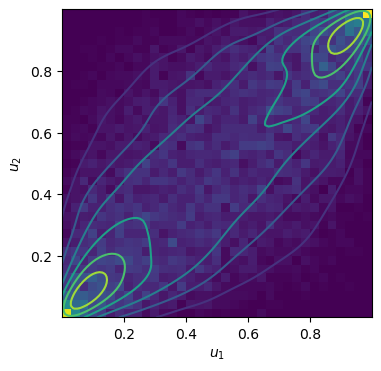

In [359]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.contour(Y1v, Y2v, Zv );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i, u_j, density=True, bins = (35,35));

In [381]:
Zv.max()

2.7387172982867805

In [397]:
C = kernel_ij.cho_cov

In [378]:
h = np.array([0.2154434690031884,0.2154434690031884])

In [377]:
U.shape[1]**(-1./(2+4))

0.2154434690031884

In [401]:
np.cov(U[[0,1],:]) * 0.2154434690031884 * 0.2154434690031884

array([[0.08219118, 0.05634665],
       [0.05634665, 0.08219667]])

In [400]:
Y_ = scipy.linalg.solve_triangular(C, np.vstack([Y1v.ravel(), Y2v.ravel()]))
U_ = scipy.linalg.solve_triangular(C, U[[0,1],:])

In [412]:
norm = 1/(2*np.pi)
estimate = np.zeros(Y_.shape[1])
for i in tqdm(range(Y_.shape[1])):
    for j in range(U_.shape[1]):
        arg = 0
        for k in range(2):
            residual = (Y_[k,i] - U_[k,j])
            arg += residual * residual

        arg = np.exp(-arg / 2.) * norm
        estimate[i] += arg
        # for k in range(p):
        #     estimate[j, k] += values_[i, k] * arg

estimate /= U_.shape[1]

100%|██████████| 10000/10000 [06:03<00:00, 27.53it/s]


In [387]:
res2D_basic = (
    np.exp( - 1/2 * ((Y1v.ravel()[None,:] - U[0,:,None])/h[0])**2) *
    np.exp( - 1/2 * ((Y2v.ravel()[None,:] - U[1,:,None])/h[1])**2) 
    ).sum(axis=0) / (h[0] * h[1] * 2*np.pi)

res2D_basic = np.reshape(res2D_basic,Y1v.shape )

res2D_basic = res2D_basic / res2D_basic.mean()

In [385]:
res2D_basic.max()

1.3625388672652539

In [420]:
# estimate /= (C[0,0] * C[1,1])
estimate.min()

0.00024203997906151252

In [421]:
Zv.min()

3.818677057098502e-06

In [432]:
import sys
import random

In [497]:
gam = 30

In [502]:
w = np.random.uniform(size = (gam))
w = w/w.sum()

In [504]:
w.shape

(30,)

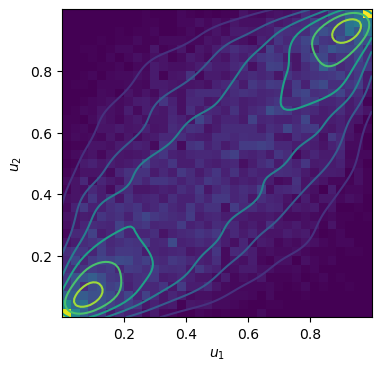

In [417]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.contour(Y1v, Y2v, np.reshape(estimate, Y1v.shape ) );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

res = plt.hist2d(u_i, u_j, density=True, bins = (35,35));

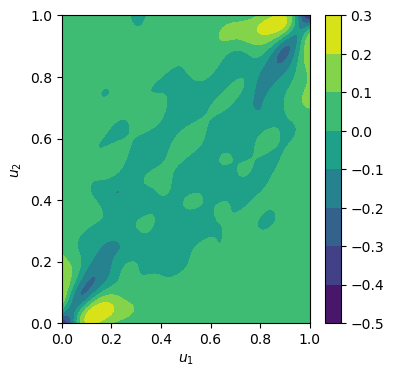

In [428]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.contourf(Y1v, Y2v, np.reshape(estimate, Y1v.shape ) - Zv );
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")
plt.colorbar()

# res = plt.hist2d(u_i, u_j, density=True, bins = (35,35));

In [ ]:
# Adaptive bandwith ()

# Source (cited in matlab file)
# Z. I. Botev, J. F. Grotowski, and D. P. Kroese (2010)
# Annals of Statistics, Volume 38, Number 5, pages 2916-2957.

In [250]:
(res2D * np.log(res2D)).mean()

1.4863648860802179

In [251]:
(res2D_basic * np.log(res2D_basic)).mean()

0.13765480456860837

In [252]:
(res2D_theoretical * np.log(res2D_theoretical)).mean()

0.3963643648851001

In [258]:
(res2D_negative * np.log(res2D_negative)).mean()

0.24707258088242626

In [266]:
(res2D_nonnegative * np.log(res2D_nonnegative)).mean()

2.236252881681233

In [253]:
-1/2 * np.log(1 - 0.7**2)

0.3366722766318828

In [168]:
res2D.max()

108.88154584738939

In [169]:
res2D_theoretical.max()

416.47413343531935

(0.0, 2.0)

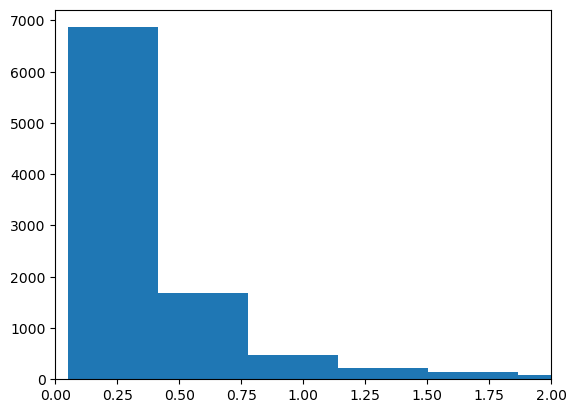

In [181]:
plt.hist(res2D.flatten(),bins=300)
plt.xlim(0,2)

In [179]:
np.quantile(res2D, 0.9)

1.1186982931654486

In [176]:
res2D.min()

0.053270613936269647

In [166]:
res2D_theoretical.sum() / np.prod(res2D_theoretical.shape)

1.0137091436144499

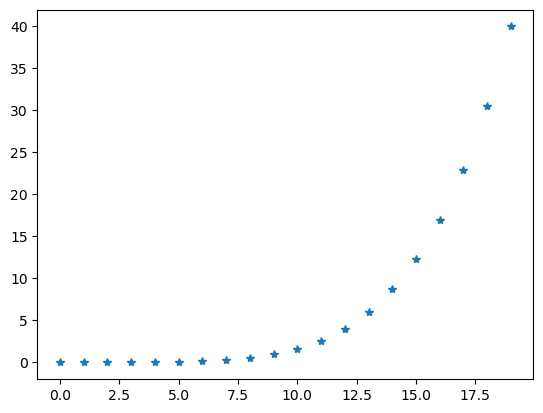

In [159]:
plt.plot(levels,'*')

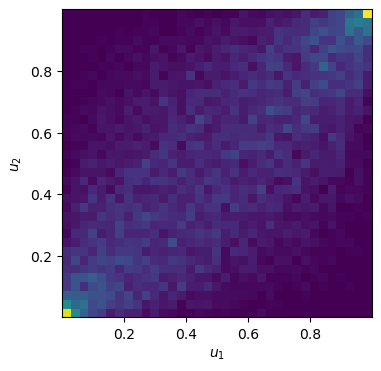

In [127]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")

plt.hist2d(U[0,:], U[1,:], density=True, bins = (35,35));

In [81]:
x_eval.shape

(100, 100)

In [79]:
res2D.max()

108.88154584738939

In [63]:
res2D.shape

(100, 100)

In [16]:
a1_all_approx

array([[[-0.02109958,  0.39841877, -0.04585221, ...,  0.00510842,
         -0.05808336,  0.23811463],
        [-0.01096622,  0.36479464, -0.00384706, ...,  0.05483765,
         -0.34941686,  0.39436276],
        [-0.00522701,  0.01101957,  0.39167082, ..., -0.0149998 ,
          0.39572738, -0.02260714],
        ...,
        [-0.00945161,  0.21439951, -0.07011427, ..., -0.05022168,
          0.3617559 ,  0.23368323],
        [-0.00556163,  0.34013373,  0.00415912, ...,  0.00594515,
          0.31906262,  0.1103074 ],
        [ 0.07245634,  0.38086002, -0.24143494, ..., -0.17712867,
          0.251837  ,  0.30249117]],

       [[-0.02108688,  0.39817898, -0.04582462, ...,  0.00510534,
         -0.0580484 ,  0.23797133],
        [-0.01095962,  0.3645751 , -0.00384474, ...,  0.05480465,
         -0.34920657,  0.39412542],
        [-0.00522387,  0.01101293,  0.3914351 , ..., -0.01499077,
          0.39548921, -0.02259353],
        ...,
        [-0.00944592,  0.21427048, -0.07007208, ..., -

In [14]:
a1_all_approx

array([[[-0.02106945,  0.39834313, -0.04579462, ...,  0.00510018,
         -0.05801392,  0.23794812],
        [-0.01094937,  0.36465285, -0.00384081, ...,  0.05477129,
         -0.34926425,  0.39426528],
        [-0.00521852,  0.01100252,  0.3915725 , ..., -0.01497732,
          0.39564666, -0.02257501],
        ...,
        [-0.00943699,  0.21423863, -0.07003431, ..., -0.05015998,
          0.36161002,  0.23351761],
        [-0.00555277,  0.3399752 ,  0.00415243, ...,  0.0059357 ,
          0.3188969 ,  0.11019659],
        [ 0.07237431,  0.38073347, -0.24126784, ..., -0.17698099,
          0.25166834,  0.30232241]],

       [[-0.02105677,  0.39810339, -0.04576706, ...,  0.00509711,
         -0.05797901,  0.23780491],
        [-0.01094278,  0.36443339, -0.00383849, ...,  0.05473833,
         -0.34905405,  0.39402799],
        [-0.00521538,  0.0109959 ,  0.39133684, ..., -0.01496831,
          0.39540855, -0.02256143],
        ...,
        [-0.00943131,  0.2141097 , -0.06999216, ..., -

In [20]:
a1_all

array([[-0.01094382,  0.1767797 , -0.35462439, ...,  0.02724135,
        -0.09178194,  0.00261091],
       [ 0.11219268,  0.00827824, -0.33090322, ...,  0.04825   ,
        -0.06567511,  0.03418271],
       [-0.3262865 ,  0.00205878, -0.22254012, ...,  0.38688228,
        -0.3631315 , -0.37342784],
       ...,
       [-0.17144902,  0.09132701,  0.25870943, ...,  0.27866632,
         0.3883578 , -0.01275577],
       [-0.07007143,  0.00902609,  0.39569314, ...,  0.00901351,
         0.37929185, -0.30335571],
       [-0.06479322,  0.34518256,  0.11769827, ..., -0.27524135,
         0.03020943, -0.04347598]])

In [27]:
scipy.stats.norm.cdf(U)

array([[0.63853932, 0.50699417, 0.72360219, ..., 0.61279956, 0.78147955,
        0.79702564],
       [0.60295661, 0.58266374, 0.69838226, ..., 0.57907029, 0.72276478,
        0.72664763],
       [0.6163848 , 0.51900259, 0.62075726, ..., 0.80639124, 0.78623637,
        0.81635557],
       ...,
       [0.76481284, 0.53343504, 0.6350906 , ..., 0.74878303, 0.63361639,
        0.80634664],
       [0.83490469, 0.56790924, 0.80608614, ..., 0.79026612, 0.64253752,
        0.54881859],
       [0.70523617, 0.719318  , 0.75372035, ..., 0.65673161, 0.69848336,
        0.74079585]])

In [576]:
u_sample = scipy.stats.uniform.rvs(size=(1000))
beta_sample = 1- (1-u_sample)**(1/4)
h = 0.05248

In [283]:
(beta_sample - beta_sample[:,None])

array([[ 0.        , -0.06198395, -0.03837344, ...,  0.30978841,
         0.04625555,  0.02419931],
       [ 0.06198395,  0.        ,  0.02361051, ...,  0.37177237,
         0.1082395 ,  0.08618326],
       [ 0.03837344, -0.02361051,  0.        , ...,  0.34816186,
         0.08462899,  0.06257275],
       ...,
       [-0.30978841, -0.37177237, -0.34816186, ...,  0.        ,
        -0.26353287, -0.28558911],
       [-0.04625555, -0.1082395 , -0.08462899, ...,  0.26353287,
         0.        , -0.02205624],
       [-0.02419931, -0.08618326, -0.06257275, ...,  0.28558911,
         0.02205624,  0.        ]])

In [297]:
(np.array([[1,2,3],[4,5,6]]) - np.array([k for k in range(4)])[:,None,None])[:,0,0]

array([ 1,  0, -1, -2])

In [285]:
[k for k in range(-5,6)]

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

(array([150., 146., 118., 108.,  98.,  64.,  73.,  48.,  46.,  27.,  26.,
         28.,  15.,  18.,  13.,   6.,  11.,   2.,   1.,   2.]),
 array([1.91454200e-04, 4.16887988e-02, 8.31861434e-02, 1.24683488e-01,
        1.66180833e-01, 2.07678177e-01, 2.49175522e-01, 2.90672866e-01,
        3.32170211e-01, 3.73667555e-01, 4.15164900e-01, 4.56662245e-01,
        4.98159589e-01, 5.39656934e-01, 5.81154278e-01, 6.22651623e-01,
        6.64148968e-01, 7.05646312e-01, 7.47143657e-01, 7.88641001e-01,
        8.30138346e-01]),
 <BarContainer object of 20 artists>)

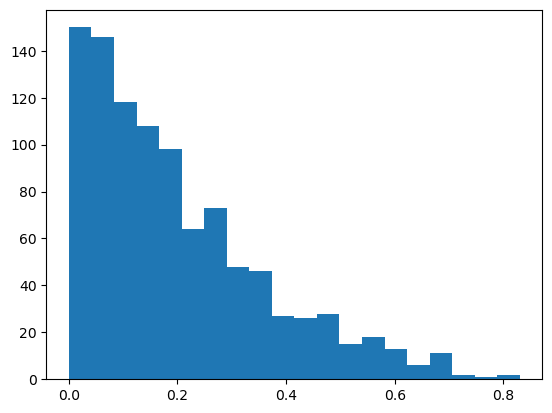

In [277]:
plt.hist(beta_sample, bins = 20)

In [574]:
xx = np.linspace(0,1,200)

(200,)

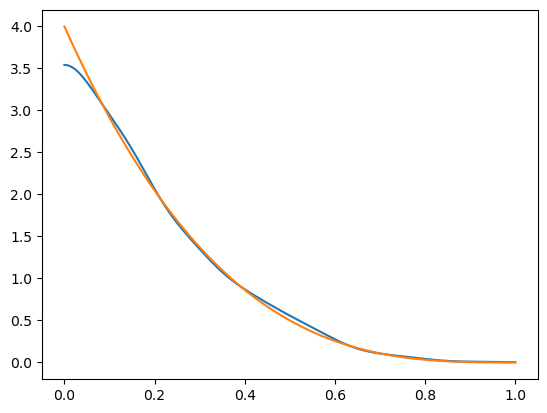

In [578]:
plt.plot(xx, eval_new(xx, beta_sample, h))
plt.plot(xx, 4*(1-xx)**3)

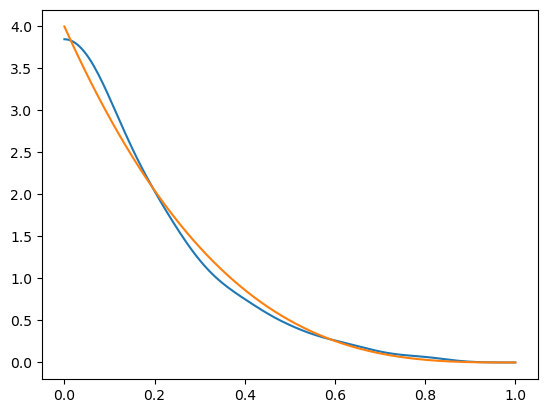

In [354]:
plt.plot(xx, eval_new(xx, beta_sample, h))
plt.plot(xx, 4*(1-xx)**3)

In [454]:
beta_sample[:,None].shape

(1000, 1)

In [459]:
if not None:
    print("ff")

ff


C:\Users\jonas\AppData\Local\Temp\ipykernel_12896\2772106210.py:73: RuntimeWarning: divide by zero encountered in log
  log_lh[:,i] = -0.5 * xRinv.sum(axis=1) - 0.5*np.log(s).sum() + np.log(w[i]) - d*np.log(2*np.pi)/2 - 0.5*del_**2 * (1/s).sum()
C:\Users\jonas\AppData\Local\Temp\ipykernel_12896\2772106210.py:111: RuntimeWarning: divide by zero encountered in log
  out += np.exp(-0.5 * xx.sum(axis=1) + np.log(w[k]) - 0.5*np.log(S).sum() - d*np.log(2*np.pi)/2)


In [838]:
def akde1d(X, grid = None, gam = None, tol = 10**-5):
    # gam: number of (randomly drawn w.o. repetition) samples from X
    (n,d) = X.shape
    if not gam:
        gam = int(np.ceil( n**(1/3) )) + 20

    
    MAX = X.max(axis=0)
    MIN = X.min(axis=0)
    scaling = MAX - MIN
    MAX = MAX + scaling / 10
    MIN = MIN - scaling / 10
    scaling = MAX - MIN

    X = X - MIN
    X = X / scaling

    
    
    # Initialize algorithm
    del_ = 0.9 / n**(d/(d+4))
    del_ = 0.05248
    perm = list(range(n)); random.shuffle(perm)

    mu = X[perm[:gam],:]
    w = np.random.uniform(size = (gam))
    w = w/w.sum()
    Sig = del_**2 * np.random.uniform(size = (gam,d))

    ent = -np.inf

    for iter in range(1_500):
        Eold = ent
        # print("entering regEM", iter)
        [w,mu,Sig,del_,ent, log_lh_mean] = regEM(w,mu,Sig,del_,X)
        err = np.abs( ( ent-Eold ) / ent)
        print(f"Iter.      Tol.           Bandwith           log lh.")
        print(f"{iter:5}     {err:10.6}      {del_:10.6}      {log_lh_mean:10.6}")
        if err < tol:             # Super weird. why not use while loop or just loop up to 200 in first place??
            break

    

    if not grid:
        grid = np.linspace(MIN, MAX, 2**12)
    
    mesh = grid - MIN
    mesh = mesh / scaling

    pdf = probfun(mesh, w, mu, Sig) / np.prod(scaling)

    del_ = scaling * del_

    print(f"final band with: {del_}")
    # print(Sig[0,:])
    # Sig : bandwith for each of the observed points

    return [pdf,grid]


def regEM(w,mu,Sig,del_,X):
    eps = sys.float_info.epsilon


    (gam,d) = mu.shape
    (n,d) = X.shape
    log_lh = np.zeros((n,gam))
    log_sig = log_lh.copy()

    for i in range(gam):
        s = Sig[i,:]
        X_centered = X - mu[i,:]
        xRinv = X_centered**2 / s
        xSig = (xRinv / s).sum(axis = 1) + eps



        log_lh[:,i] = -0.5 * xRinv.sum(axis=1) - 0.5*np.log(s).sum() + np.log(w[i]) - d*np.log(2*np.pi)/2 - 0.5*del_**2 * (1/s).sum()
        log_sig[:,i] = log_lh[:,i] + np.log(xSig)

    # print(log_lh.max(axis=1).mean())

    maxll = log_lh.max(axis=1)
    maxlsig = log_sig.max(axis=1)
    p = np.exp(log_lh - maxll[:,None])
    # print(p.shape)
    psig = np.exp(log_sig - maxlsig[:,None])
    density = p.sum(axis=1)
    psigd = psig.sum(axis=1)
    logpdf = np.log(density) + maxll
    logpsigd = np.log(psigd) + maxlsig
    p = p/density[:,None]
    ent = logpdf.sum()
    w = p.sum(axis=0)


    # print((p[:,i] @ X).shape)
    for i in np.where(w > 0)[0]:

        mu[i,:] = p[:,i] @ X / w[i]
        X_centered = X - mu[i,:]
        Sig[i,:] = p[:,i] @ X_centered**2/w[i] + del_**2

    w = w/w.sum()
    curv = np.exp(logpsigd - logpdf).mean()
    del_ = 1/(4 * n * (4*np.pi)**(d/2)* curv)**(1/(d+2))

    return [w, mu, Sig, del_, ent, log_lh.max(axis=1).mean()]


def probfun(x,w,mu,Sig):
    # print(Sig.shape)
    (gam,d) = mu.shape
    out = 0
    for k in range(gam):
        S = Sig[k,:]
        xx = x - mu[k,:]
        xx = xx**2 / S
        out += np.exp(-0.5 * xx.sum(axis=1) + np.log(w[k]) - 0.5*np.log(S).sum() - d*np.log(2*np.pi)/2)
    
    return out

In [839]:
def eval_new(x_eval, x_i, h):
    N_kernels = 6
    p1 = x_eval - x_i[:,None]
    p2 = x_eval + x_i[:,None]

    p1 = (p1 - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[:,None,None])/h
    p2 = (p2 - np.array([2*k for k in range(-N_kernels,N_kernels+1)])[:,None,None])/h


    return (scipy.stats.norm().pdf(p1).sum(axis=(0)).mean(axis=0) + scipy.stats.norm().pdf(p2).sum(axis=0).mean(axis=0) )/h

In [840]:
u_sample = scipy.stats.uniform.rvs(size=(1_000))
# beta_sample = 1- (1-u_sample)**(1/4)
# beta_sample = 1/2 + np.cbrt(((2*u_sample - 1 )/8))
beta_sample = u_sample

def pdf_fun(x):
    # return 12 * (x-0.5)**2
    return np.ones(x.shape)

h = 0.05248

In [843]:
[akde1d_pdf, akde1d_grid] = akde1d(beta_sample[:,None] , gam = int(beta_sample.shape[0]*0.03), tol = 10**-5)

Iter.      Tol.           Bandwith           log lh.
    0            inf      0.00439896        -2.01427
Iter.      Tol.           Bandwith           log lh.
    1        11.2707      0.00687743       -0.902414
Iter.      Tol.           Bandwith           log lh.
    2       0.108073      0.00650275       -0.884057
Iter.      Tol.           Bandwith           log lh.
    3      0.0235291      0.00639573       -0.881254
Iter.      Tol.           Bandwith           log lh.
    4      0.0150605      0.00632167       -0.878072
Iter.      Tol.           Bandwith           log lh.
    5      0.0139014      0.00625661       -0.872057
Iter.      Tol.           Bandwith           log lh.
    6      0.0142034      0.00618982       -0.863138
Iter.      Tol.           Bandwith           log lh.
    7      0.0147979      0.00611474       -0.853154
Iter.      Tol.           Bandwith           log lh.
    8      0.0147814      0.00602847       -0.842866
Iter.      Tol.           Bandwith           l

In [78]:
0.00288878**0.5

0.05374737202877923

In [8]:
h = 0.05248
# h = 0.002898478977138347
# h = 0.04716675988996803**2


xx = np.linspace(0,1,200)

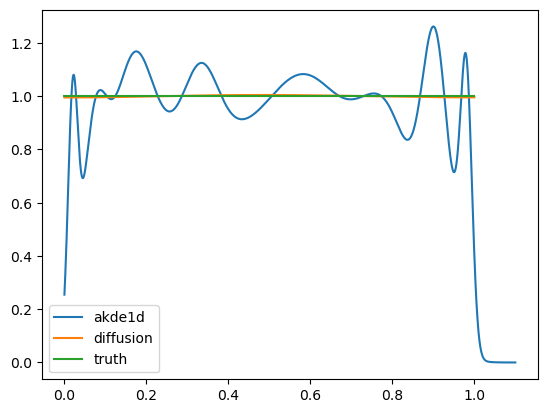

In [9]:
plt.plot(akde1d_grid[akde1d_grid.ravel() >= 0],akde1d_pdf[akde1d_grid.ravel() >= 0], label = "akde1d")
plt.plot(xx, eval_new(xx, beta_sample, 0.3), label = "diffusion")
# plt.plot(xx, 4*(1-xx)**3)
plt.plot(xx,pdf_fun(xx), label = "truth")

plt.legend()

In [39]:
res = gaussian_kde(beta_sample)

In [37]:
scott_factor = beta_sample.shape[0] ** (-1 / (1+4))
scott_factor

0.251188643150958

In [51]:
res.covariance ** 0.5

array([[0.07166918]])

In [52]:
res.cho_cov

array([[0.07166918]])

In [53]:
(beta_sample.var() * scott_factor**2)**0.5

0.07163333272517132

In [54]:
h = 0.07163333272517132
a0 = ComputeA0(beta_sample[:,None], np.array([h]))
a1 = ComputeA1Approx(beta_sample[:,None], np.array([h]), 1_000)
a2 = ComputeA2Approx(beta_sample[:,None], np.array([h]), 1_000)

In [15]:
res = special_func(xx, beta_sample[:,None], np.array([h]), n_int = 3_000)

In [30]:
beta_sample[:,None].shape

(1000, 1)

In [57]:
res = (((a2 - a1* (xx[None,:] - beta_sample[:,None])/h ) / (a2 * a0 - a1**2) )  * np.exp( - 1/2 * ((xx[None,:] - beta_sample[:,None])/h)**2) ).mean(axis=0) / (h * np.sqrt(2*np.pi))

In [26]:
(((a2 - a1* (xx[None,:] - beta_sample[:,None])/h ) / (a2 * a0 - a1**2) )  * np.exp( - 1/2 * ((xx[None,:] - beta_sample[:,None])/h)**2)).shape

(1000, 200)

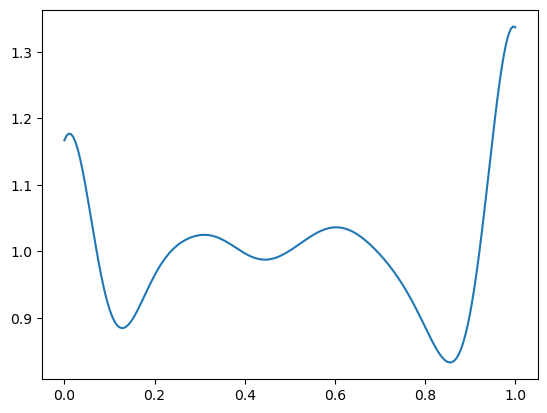

In [58]:
plt.plot(xx, res)

In [81]:
(pdf_fun(xx) * np.log(pdf_fun(xx))).mean()

0.0

In [82]:
(akde1d_pdf[(akde1d_grid.ravel() >= 0) &(akde1d_grid.ravel() <= 1)] * np.log(akde1d_pdf[(akde1d_grid.ravel() >= 0) &(akde1d_grid.ravel() <= 1)])).mean()

0.005124796724708612

In [83]:
(eval_new(xx, beta_sample, h)  * np.log(eval_new(xx, beta_sample, h)) ).mean()

0.0018634087030947176

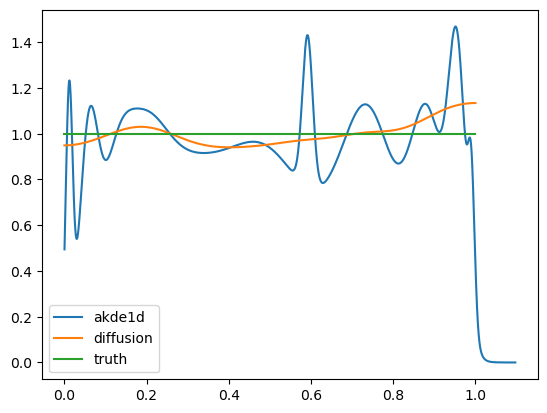

In [93]:
plt.plot(akde1d_grid[akde1d_grid.ravel() >= 0],akde1d_pdf[akde1d_grid.ravel() >= 0], label = "akde1d")
plt.plot(xx, eval_new(xx, beta_sample, h), label = "diffusion")
# plt.plot(xx, 4*(1-xx)**3)
plt.plot(xx,pdf_fun(xx), label = "truth")

plt.legend()

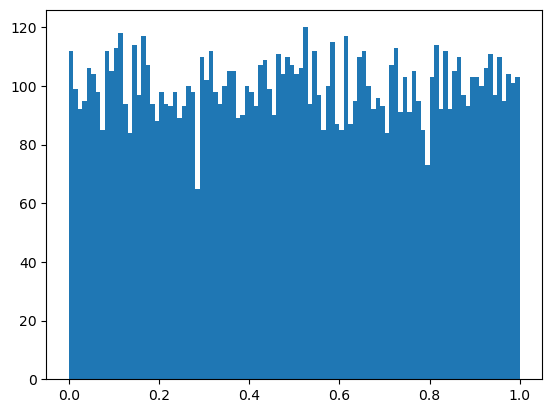

In [75]:
plt.hist(beta_sample,bins = 100);

In [350]:
eval_new(xx, beta_sample, h).mean()

1.0046205151244951

In [307]:
np.array([2*k for k in range(-5,6)])[:,None,None].shape

(11, 1, 1)

In [318]:
xx.shape


(200,)

In [319]:
beta_sample.shape

(1000,)

In [320]:
p1 = xx - beta_sample[:,None]
p1.shape

(1000, 200)

In [334]:
(p1 - np.array([2*k for k in range(-5,6)])[:,None,None]).sum(axis=0).mean(axis=0)

array([-2.19774431, -2.14246793, -2.08719154, -2.03191516, -1.97663878,
       -1.9213624 , -1.86608602, -1.81080964, -1.75553325, -1.70025687,
       -1.64498049, -1.58970411, -1.53442773, -1.47915134, -1.42387496,
       -1.36859858, -1.3133222 , -1.25804582, -1.20276943, -1.14749305,
       -1.09221667, -1.03694029, -0.98166391, -0.92638752, -0.87111114,
       -0.81583476, -0.76055838, -0.705282  , -0.65000562, -0.59472923,
       -0.53945285, -0.48417647, -0.42890009, -0.37362371, -0.31834732,
       -0.26307094, -0.20779456, -0.15251818, -0.0972418 , -0.04196541,
        0.01331097,  0.06858735,  0.12386373,  0.17914011,  0.2344165 ,
        0.28969288,  0.34496926,  0.40024564,  0.45552202,  0.5107984 ,
        0.56607479,  0.62135117,  0.67662755,  0.73190393,  0.78718031,
        0.8424567 ,  0.89773308,  0.95300946,  1.00828584,  1.06356222,
        1.11883861,  1.17411499,  1.22939137,  1.28466775,  1.33994413,
        1.39522052,  1.4504969 ,  1.50577328,  1.56104966,  1.61

C:\Users\jonas\AppData\Local\Temp\ipykernel_11048\1762279602.py:2: RuntimeWarning: divide by zero encountered in log
  y = xx*np.log(xx)
C:\Users\jonas\AppData\Local\Temp\ipykernel_11048\1762279602.py:2: RuntimeWarning: invalid value encountered in multiply
  y = xx*np.log(xx)


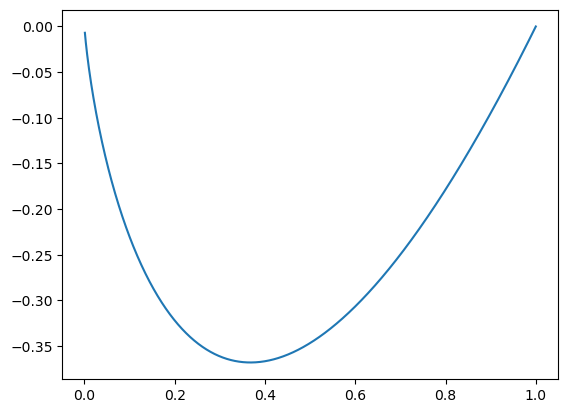

In [6]:
xx = np.linspace(0,1,1000)
y = xx*np.log(xx)
plt.plot(xx,y)

In [290]:
np.linalg.eig(N).eigenvalues

array([-2.05671624+0.j        , -1.18583108+0.47481355j,
       -1.18583108-0.47481355j,  0.73803269+0.98150084j,
        0.73803269-0.98150084j, -0.09632471+1.10675427j,
       -0.09632471-1.10675427j, -0.40906441+0.j        ,
       -0.12767589+0.j        ,  0.99307117+0.j        ])

In [815]:
d = 10
N = scipy.stats.uniform.rvs(size = (d,d)) * 2 - 1
N *= 1/d *0.5

print( ( np.linalg.eig(N.T @ N).eigenvalues.max()**0.5 ) * np.sqrt(200))
print( ((N**2).sum() ** 0.5) )

# G_obs *= 0.9

G_obs_hat = G_obs.copy() + N

G_dir = G_obs @ np.linalg.pinv(np.identity(10) + G_obs)
G_dir_hat = G_obs_hat @ np.linalg.pinv(np.identity(10) + G_obs_hat)


temp = G_dir - G_dir_hat
print(f"spectral norm Gdir - app. G_dir:         {np.linalg.eig(temp.T @ temp).eigenvalues.max()**0.5}")

print(f"max singular value (spectral norm) of N: {np.linalg.eig(N.T @ N).eigenvalues.max()**0.5}")


print(f"{np.linalg.eig(N.T @ N).eigenvalues.max()**0.5} <= {np.linalg.eig(temp.T @ temp).eigenvalues.max()**0.5}" )


gamma = np.linalg.eig(N.T @ N).eigenvalues.max()**0.5
delta = np.linalg.eig( G_obs.T @ G_obs).eigenvalues.max()**0.5

gamma_frob = (N**2).sum()**0.5
delta_frob = (G_obs**2).sum()**0.5

print(f"gamma + delta:         {gamma + delta}")
print(f"gamma + delta sqrt(d): {np.sqrt(d)* (gamma + delta)}")
print(f"gamma + delta frob:    {gamma_frob + delta_frob}")

print(f"gamma: {gamma}, delta : {delta}")

# print(f"{gamma + (gamma**2 + 2*delta*gamma) + (gamma**3 + 3*delta*gamma**2 + 3*delta**2 * gamma)}")


print(f"spec-norm dir diff.: {np.linalg.eig(temp.T @ temp).eigenvalues.max()**0.5} <= {(gamma + delta) / (1 - gamma - delta) - delta / (1 - delta)}")
print(f"frob-norm dir diff.: { (temp**2).sum()**0.5 } <= {np.sqrt(d)*(gamma + delta) / (1 - np.sqrt(d)*(gamma + delta)) - np.sqrt(d)*delta / (1 - np.sqrt(d)*delta)}")

print(f"frob-norm dir diff.: { (temp**2).sum()**0.5 } <= {(gamma_frob + delta_frob) / (1 - delta_frob - gamma_frob) - delta_frob / (1 - delta_frob)}")

2.15761878837839
0.2719441744358843
spectral norm Gdir - app. G_dir:         0.15392785903675613
max singular value (spectral norm) of N: 0.1525666876477862
0.1525666876477862 <= 0.15392785903675613
gamma + delta:         0.3119094925401448
gamma + delta sqrt(d): 0.9863444202541556
gamma + delta frob:    0.5177646585265235
gamma: 0.1525666876477862, delta : 0.15934280489235855
spec-norm dir diff.: 0.15392785903675613 <= 0.26375166896125374
frob-norm dir diff.: 0.2773443747553222 <= 71.21447225141094
frob-norm dir diff.: 0.2773443747553222 <= 0.7477320430004237


In [798]:
np.linalg.eig(N.T @ N).eigenvalues.max()**0.5

0.1561700356932287

In [799]:
(N**2).sum()**0.5

0.29806799635662656

In [773]:
np.sqrt(d)

3.1622776601683795

In [414]:
np.linalg.eig(G_obs_hat).eigenvalues

array([ 0.5080954 +0.j        ,  0.35588226+0.j        ,
       -0.37796464+0.j        ,  0.21144364+0.j        ,
       -0.25461169+0.j        , -0.17628374+0.j        ,
       -0.15640165+0.j        ,  0.00830417+0.06374308j,
        0.00830417-0.06374308j,  0.07823272+0.j        ])

In [419]:
# G_obs_hat - (G_dir_hat + G_dir_hat@G_dir_hat + G_dir_hat@G_dir_hat@G_dir_hat + G_dir_hat@G_dir_hat@G_dir_hat@G_dir_hat)

In [399]:
temp = G_dir_hat.copy()
sum = G_dir_hat.copy()
for i in range(10):
    temp @= G_dir_hat
    sum += temp

In [416]:
print(f"Largest absolute eig-value of N: {np.abs(np.linalg.eig(N).eigenvalues).max()}")
print(f"Largest absolute sig-value of N: {np.linalg.eig(N.T @ N).eigenvalues.max()**0.5}")

Largest absolute eig-value of N: 0.25088497660402104
Largest absolute sig-value of N: 0.31390453669546925


gamma: 0.31390453669546925, delta : 0.41765209584994906


0.6746463701488064

In [645]:
d = 10

for i in range(10_000):
    N = scipy.stats.uniform.rvs(size = (d,d)) * 2 - 1
    N2  = scipy.stats.uniform.rvs(size = (d,d)) * 2 - 1
    # N *= 1/d

    temp = N2 @ N
    # print(f"Gobs @ N s: {np.linalg.eig(temp.T @ temp).eigenvalues.max()**0.5}")

    gamma = np.linalg.eig(N.T @ N).eigenvalues.max()**0.5
    # delta = np.linalg.eig( G_obs.T @ G_obs).eigenvalues.max()**0.5
    delta = np.linalg.eig( N2.T @ N2).eigenvalues.max()**0.5
    # print(f"sG * sN:    {gamma*delta}")
    if (gamma*delta <= np.linalg.eig(temp.T @ temp).eigenvalues.max()**0.5):
        print("sssss")

In [709]:
np.linalg.eig(G_obs.T @ G_obs).eigenvalues.max()

17.4433273167855

In [711]:
np.linalg.eig(G_dir.T @ G_dir).eigenvalues

array([1.85338859e+02, 2.48902833e+00, 2.34584180e+00, 1.65785982e+00,
       6.50958612e-01, 5.14073597e-01, 4.38869642e-01, 1.71852717e-01,
       1.41414465e-02, 2.62438052e-02])

In [710]:
G_dir = G_obs @ np.linalg.pinv(np.identity(10) + G_obs)

In [714]:
np.linalg.eig(G_obs).eigenvalues

array([ 4.17652096,  2.5334348 , -2.73110572, -2.88106367,  0.70809136,
       -0.9315721 ,  0.19331657, -0.10627931, -0.39848624, -0.56285664])

In [117]:
Y.shape

(10, 10000)

In [ ]:
n_samples = x.shape[1]
F_H = lambda x : np.min( [np.ones(x.shape), np.max( np.vstack([x , np.zeros(x.shape)]) , axis = 0)], axis = 0 )
xx = np.linspace(0,1,10_000)
D_N = np.abs((U <= xx[:,None]).mean(axis=1) - F_H(xx)).max()
print(f"Kolmogorov Smirnov test stat. :      {D_N}")
D_N_adjusted = ( np.sqrt(n_samples) + 0.12 + 0.11/np.sqrt(n_samples) ) * D_N
print(f"Adj. Kolmogorov Smirnov test stat. : {D_N_adjusted}")
# print(f"95% crit. value :                    {1.358}\n")
print(f"p-value :                            {scipy.special.kolmogorov(D_N_adjusted)}")

In [214]:
U = np.random.uniform(0,1,1000)

KolmogorovSmirnovTestUnif(U)

Test-stat. :          0.025430443044304418
Adjusted test-stat. : 0.8073213323713185
p-value :             0.5322778025651613


(0.025430443044304418, 0.8073213323713185, 0.5322778025651613)

100%|██████████| 10000/10000 [00:32<00:00, 306.64it/s]


(array([1007.,  981.,  980.,  982., 1038.,  981.,  980.,  986.,  962.,
        1103.]),
 array([4.00836902e-05, 1.00029575e-01, 2.00019065e-01, 3.00008556e-01,
        3.99998047e-01, 4.99987538e-01, 5.99977029e-01, 6.99966520e-01,
        7.99956011e-01, 8.99945501e-01, 9.99934992e-01]),
 <BarContainer object of 10 artists>)

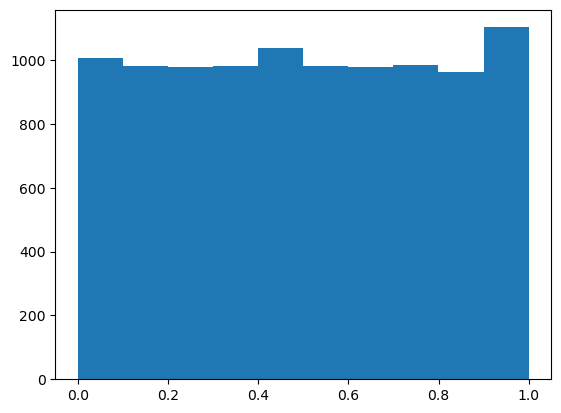

In [149]:
temp = np.full(10000, np.nan)

for i in tqdm(range(10_000)):
    U = np.random.uniform(0,1,100)
    temp[i] = KolmogorovSmirnovTestUnif(U)[2]

plt.hist(temp)